In [2]:
import numpy as np
from matplotlib import pyplot
from IPython.display import Image

In [3]:
import MNISTtools

In [4]:
xtrain, ltrain = MNISTtools.load(dataset='training', path = 'F:\\UCSD\\Quarter1\\ECE285\\Assignments\\Assignment1')

In [5]:
print(xtrain.shape)
print(ltrain.shape)

(784, 60000)
(60000,)


size of training dataset: 60000

size of feature dimension: 784

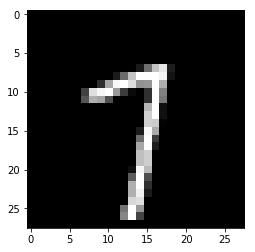

7


In [6]:
%matplotlib inline
image42 = xtrain[:,42]
image42_reshaped = np.reshape(image42, (28,28))
pyplot.imshow(image42_reshaped, cmap='gray')
pyplot.show()
print(ltrain[42])

We observe that the content corresponds to the label.

In [7]:
minim = np.min(xtrain)
maxim = np.max(xtrain)
xtrain_range = maxim - minim
print(minim)
print(maxim)
print(xtrain_range)
xtrain.dtype

0
255
255


dtype('uint8')

In [8]:
def normalize_MNIST_images(x):
    y = x.astype(np.float32)
    divisor = 255/2
    y_new_range = (y/divisor)-1
    return y_new_range

In [9]:
xtrain = normalize_MNIST_images(xtrain)
minim = np.min(xtrain)
maxim = np.max(xtrain)
xtrain_newrange_range = maxim - minim
print(minim)
print(maxim)
print(xtrain_newrange_range)
xtrain.dtype

-1.0
1.0
2.0


dtype('float32')

In [10]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d

In [11]:
print(ltrain[42])
dtrain = label2onehot(ltrain)
print(dtrain[:,42])
print(dtrain.shape)
print(ltrain.shape)

7
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
(10, 60000)
(60000,)


In [12]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [13]:
x = onehot2label(dtrain)
print(x)
print(x[42])

[5 0 4 ..., 5 6 8]
7


In [14]:
def softmax(a):
    a_max = np.zeros((1,60000))
    a_max = a.max(axis = 0)
    a_sane = a - a_max
    a_sane_exp = np.exp(a_sane)
    y = a_sane_exp/(a_sane_exp.sum(axis = 0))
    return y

In [15]:
def softmaxp(a,e):
    k = softmax(a)
    part1 = np.multiply(k,e)
    new = part1.sum(axis = 0)
    part2 = np.multiply(new.T,k)
    return(part1 - part2)

Checking if softmax and softmaxp work correctly

In [16]:
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff = softmaxp(a, e)
diff_approx = (softmax(a + (eps*e)) - softmax(a))/eps
rel_error = np.abs(diff - diff_approx).mean() / np.abs(diff_approx).mean()
print(rel_error, 'should be smaller than 1e-6')

5.11569689137e-07 should be smaller than 1e-6


Implementing ReLU and ReLUp

In [17]:
def relu(a):
    return(np.where(a>0,a,0))

In [18]:
def relup(a,e):
#    for i in range(a.shape[0]):
#        for j in range(a.shape[1]):
#            if a[i][j]>0:
#                a[i][j] = 1
#            else:
#                a[i][j] = 0 
#    a[a>0]=1
    a = np.where(a>0,1,0)
    return(a*e)

Checking if relu and relup work correctly

In [19]:
eps = 1e-6 # finite difference step
a = np.random.randn(10, 200) # random inputs
e = np.random.randn(10, 200) # random directions
diff2 = relup(a, e)
#print(diff)
diff_approx2 = (relu(a + (eps*e)) - relu(a))/eps
#print(diff_approx)
rel_error2 = (np.abs(diff2 - diff_approx2)).mean() / np.abs(diff_approx).mean()
print(rel_error2, 'should be smaller than 1e-6')

2.33952738812e-10 should be smaller than 1e-6


Initializing Shallow Net

In [20]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = xtrain.shape[0]
Nh = 64
No = dtrain.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [21]:
def forwardprop_shallow(x, net):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    return y
yinit = forwardprop_shallow(xtrain, netinit)

Evaluating Loss

In [22]:
def eval_loss(y, d):
    sum_vert = -np.log(y)*d
    return(sum_vert.sum()/y.shape[1])
print(eval_loss(yinit, dtrain), 'should be around .26')

2.95753902803 should be around .26


Evaluating Performance

In [23]:
def eval_perfs(y, lbl):
    y_oneD = onehot2label(y)
    perf_par = (y_oneD != lbl)
    sum_perf_par = perf_par.sum()
    return (sum_perf_par/lbl.shape[0])*100
print(eval_perfs(yinit, ltrain))

93.3283333333


In [24]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    e2 = - d / y
    delta2 = softmaxp(a2,e2)
    e1 = W2.T.dot(delta2)
    delta1 = relup(a1, e1) 
    W2 = W2 - gamma * delta2.dot(a1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis =1, keepdims = True )
    b1 = b1 - gamma * delta1.sum(axis =1, keepdims = True )
    return W1, b1, W2, b2

In [25]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x, d, net)
        #net = [W1,b1,W2,b2]
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y, d)
        print(loss)
        performance = eval_perfs(y, lbl)
        print(performance)
    return net

In [26]:
nettrain_batch = backprop_shallow(xtrain, dtrain, netinit, 100)

2.51097931787
88.1716666667
2.26106138433
84.14
2.13687675119
78.2733333333
2.03757017369
72.5966666667
1.95209051349
67.2516666667
1.87278327946
61.37
1.80371494753
59.2366666667
1.73954684901
53.5166666667
1.69275255909
54.9183333333
1.64887365985
50.0283333333
1.64453456806
53.96
1.60946652714
47.975
1.60114327013
52.3333333333
1.53341269248
43.955
1.47533974855
47.6016666667
1.41589532622
39.4583333333
1.35308947861
41.9533333333
1.3046211098
35.6116666667
1.24906149621
37.0466666667
1.21225368507
32.7216666667
1.16371780423
33.2916666667
1.13889145035
30.8516666667
1.0943674923
30.5166666667
1.07956902607
29.515
1.03751277
28.5183333333
1.02935357453
28.63
0.989338797323
26.9716666667
0.984790746541
27.82
0.947039503819
25.7083333333
0.944181906989
26.985
0.908869030794
24.5816666667
0.906756450304
26.1783333333
0.873873118249
23.6616666667
0.872045053721
25.3166666667
0.841527649205
22.7883333333
0.839885308179
24.475
0.81173036966
22.0183333333
0.810240922035
23.5116666667
0.784

#### Question 19

In [32]:
xtest, ltest = MNISTtools.load(dataset='testing', path = 'F:\\UCSD\\Quarter1\\ECE285\\Assignments\\Assignment1')

In [33]:
print(xtest.shape)
print(ltest.shape)

(784, 10000)
(10000,)


In [34]:
xtest = normalize_MNIST_images(xtest)
dtest = label2onehot(ltest)
ytest = forwardprop_shallow(xtest, nettrain_batch)
perf = eval_perfs(ytest, ltest)
print(perf)

12.07


Training Mini Batch Gradient Descent on the same data

In [35]:
def backprop_minibatch_shallow(x, d, net, T, B=100, gamma=.05):
    N = x.shape[1]
    NB = int((N+B-1)/B)
    lbl = onehot2label(d)
    for t in range(T):
        shuffled_indices = np.random.permutation(range(N))
        for l in range(NB):
            minibatch_indices = shuffled_indices[B*l:min(B*(l+1), N)]
            #COMPLETE TO UPDATE NET
            net = update_shallow(x[:,shuffled_indices], d[:,shuffled_indices], net)
        y = forwardprop_shallow(x, net);
        #COMPLETE TO DISPLAY LOSS AND PERFS
        loss = eval_loss(y, d);
        print(loss)
        perf = eval_perfs(y, lbl);
        print(perf)
    return net

In [36]:
nettrain = backprop_minibatch_shallow(xtrain, dtrain, netinit, 5, B=100, gamma=.05)

0.282351495798
8.07833333333
0.222290940262
6.23833333333
0.184813342844
5.23333333333
0.158335527491
4.44
0.138874640026
3.87


Testing the performance of Mini Batch Gradient Descent

In [38]:
ytest = forwardprop_shallow(xtest, nettrain)
perf = eval_perfs(ytest, ltest)
print(perf)

4.24


We observe that Mini Batch Gradient Descent performs much better than Batch Gradient Descent.